### Submission Task

Submit a Python file for fitting the model on the Premier League. This code should run without error with standard libraries (mplsoccer ok) if put in the same directory as the events_England.json.

Points will be awarded for the novelty of the metric, the clarity of the explanation, the quality and correctness of the code and for the technical difficulty of the contribution.

#### Import Packages

In [183]:
import os 
import pathlib
import json
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from itertools import combinations_with_replacement
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import seaborn as sns

#### Import Test and Train Data

In [2]:
#Needs to run in the same directory

def import_events(country):
    file_name = f'events_{country}.json'
    path = os.path.join(str(pathlib.Path().resolve()),   file_name)
    with open(path) as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df = df.reset_index()
    return df

In [8]:
df_train = import_events('England')

In [9]:
df_test = import_events('Germany')

#### Create Possession Chains

In [42]:
## Prepare Data

def prep_possession_chains(df):
    """
    This function performs the following steps:
    1. Adds a new column `nextEvent` which holds the subEventName of the next row.
    2. Adds a column `kickedOut` that flags events where the next event is 'Ball out of the field'.
    3. Removes rows with specific types of events that are not relevant for possession chains, 
       including non-accurate duels, interruptions, and goalkeeping events.
    4. Filters out events where the ball is out of the field.

    Parameters:
    The input dataframe of event data.

    Returns:
    A cleaned dataframe with filtered events.
    """
    
    # Shift the dataframe to get the next event in the sequence
    next_event = df.shift(-1, fill_value=0)
    df["nextEvent"] = next_event["subEventName"]
    
    # Add a flag for events that are followed by 'Ball out of the field'
    df["kickedOut"] = df.apply(
        lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis=1
    )

    # Filter out interruptions
    interruption = df.loc[df["eventName"] == "Interruption"]

    # Filter out non-accurate duels
    lost_duels = df.loc[df["eventName"] == "Duel"]
    lost_duels = lost_duels.loc[
        lost_duels.apply(lambda x: {'id': 1802} in x.tags, axis=1)
    ]
    df = df.drop(lost_duels.index)

    # Filter out 'Ball out of the field' events
    out_of_ball = df.loc[df["subEventName"] == "Ball out of the field"]
    df = df.drop(out_of_ball.index)

    # Drop goalkeeping-related events
    goalies = df.loc[
        df["subEventName"].isin(["Goalkeeper leaving line", "Save attempt", "Reflexes"])
    ]
    df = df.drop(goalies.index)

    return df



df_prep_possession_chains_train = prep_possession_chains(df_train)
df_prep_possession_chains_test = prep_possession_chains(df_test)

## Isolate Chains

def isolate_chains(df):
    """
    The function analyzes the sequence of events and assigns a possession chain 
    identifier for each row, indicating when a team's possession started and 
    ended. This is done by evaluating event types, event outcomes, and team IDs 
    to identify changes in possession.

    Parameters
    ----------
    Dataframe. It must contain columns like 
        'teamId', 'eventName', 'tags', 'matchPeriod', 'kickedOut', etc.

    Returns
    -------
    A dataframe with two additional columns:
        - 'possession_chain': Numeric identifier for each possession chain.
        - 'possession_chain_team': Team ID corresponding to the possession chain.
    """
    
    df["nextTeamId"] = df.shift(-1, fill_value=0)["teamId"]
    
    # Initialize variables for tracking possession chains
    chain_team = df.iloc[0]["teamId"]
    period = df.iloc[0]["matchPeriod"]
    stop_criterion = 0
    chain = 0
    df["possession_chain"] = 0
    df["possession_chain_team"] = 0

    # Iterate through the dataframe to identify and mark possession chains
    for i, row in df.iterrows():
        # Assign current chain values
        df.at[i, "possession_chain"] = chain
        df.at[i, "possession_chain_team"] = chain_team

        # Check for specific events (passes, duels) that affect possession
        if row["eventName"] in ["Pass", "Duel"]:
            if row["teamId"] == chain_team and {"id": 1802} in row["tags"]:
                stop_criterion += 1
            if row["teamId"] != chain_team and {"id": 1801} in row["tags"]:
                stop_criterion += 1
        
        # Ball intercepted event (Others on the ball)
        if row["eventName"] == "Others on the ball" and row["teamId"] == row["nextTeamId"]:
            stop_criterion += 2
        
        # Events that result in an immediate possession stop
        if row["eventName"] in ["Shot", "Foul", "Offside"]:
            stop_criterion += 2
        
        # Ball out of play
        if row["kickedOut"] == 1:
            stop_criterion += 2
        
        # Possession chain ends if the match period changes
        if row["matchPeriod"] != period:
            chain += 1
            stop_criterion = 0
            chain_team = row["teamId"]
            period = row["matchPeriod"]
            df.at[i, "possession_chain"] = chain
            df.at[i, "possession_chain_team"] = chain_team
        
        # If stop criterion is met (i.e., possession ends)
        if stop_criterion >= 2:
            chain += 1
            stop_criterion = 0
            chain_team = row["nextTeamId"]

    return df


df_isolated_possession_chains_train = isolate_chains(df_prep_possession_chains_train)
df_isolated_possession_chains_test = isolate_chains(df_prep_possession_chains_test)

#Calculate xG

def calculate_xG(df):
    """
    Calculates the expected goals (xG) for each shot in the provided Wyscout event data.

    Parameters
    ----------
    Dataframe with wyscout possession chains.

    Returns
    -------
        The input dataframe with an additional column 'xG', representing the 
        calculated expected goals for each shot event.
    """
    # Filter only the shot events
    shots = df.loc[df["eventName"] == "Shot"].copy()
    
    # Calculate X, Y, and C coordinates for the shot locations
    shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105 / 100)
    shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68 / 100)
    shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68 / 100)

    # Calculate the distance and angle for each shot
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(
        np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0,
        np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)),
        np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi
    )
    
    # Label goals in the shot data
    shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id': 101} in x else 0).astype(object)

    # Separate headers and non-headers
    headers = shots.loc[shots.apply(lambda x: {'id': 403} in x.tags, axis=1)]
    non_headers = shots.drop(headers.index)

    # Build logistic regression models for headers and non-headers
    headers_model = smf.glm(formula="Goal ~ Distance + Angle", data=headers,
                            family=sm.families.Binomial()).fit()
    nonheaders_model = smf.glm(formula="Goal ~ Distance + Angle", data=non_headers,
                               family=sm.families.Binomial()).fit()

    # Initialize xG column in the dataframe
    df["xG"] = 0
    df["xG"] = df["xG"].astype(float)  # Cast to float before assigning xG values

    # Calculate xG for headers
    b_head = headers_model.params
    xG = 1 / (1 + np.exp(b_head.iloc[0] + b_head.iloc[1] * headers["Distance"] + b_head.iloc[2] * headers["Angle"]))
    headers = headers.assign(xG=xG)
    for index, row in headers.iterrows():
        df.at[index, "xG"] = row["xG"]

    # Calculate xG for non-headers
    b_nhead = nonheaders_model.params
    xG = 1 / (1 + np.exp(b_nhead.iloc[0] + b_nhead.iloc[1] * non_headers["Distance"] + b_nhead.iloc[2] * non_headers["Angle"]))
    non_headers = non_headers.assign(xG=xG)
    for index, row in non_headers.iterrows():
        df.at[index, "xG"] = row["xG"]

    # Handle penalties (treating them as a specific shot type)
    penalties = df.loc[df["subEventName"] == "Penalty"].copy()
    penalties["X"] = 11
    penalties["Distance"] = 11
    penalties["Angle"] = np.arctan(7.32 * 11 / (11**2 - (7.32 / 2)**2))
    penalties["Goal"] = penalties.tags.apply(lambda x: 1 if {'id': 101} in x else 0).astype(object)
    penalties = penalties.assign(xG=xG)
    for index, row in penalties.iterrows():
        df.at[index, "xG"] = row["xG"]

    return df


df_isolated_possession_chains_xg_train = calculate_xG(df_isolated_possession_chains_train)
df_isolated_possession_chains_xg_test = calculate_xG(df_isolated_possession_chains_test)


## Prepare Chains

def prepare_chains(df):
    """
    Prepares possession chains by assigning shot outcomes (xG) to events that 
    are part of a shot-ending possession chain, and updates previous chains if 
    they ended in a foul instead of a shot.

    Parameters
    ----------
        Possession chain DF.

    Returns
    -------
        DF with updated xG values and shot-end flags for each possession 
        chain. Only events related to the possession team are retained.
    """
    
    df["shot_end"] = 0  # Initialize shot_end column
    no_chains = max(df["possession_chain"].unique())  # Get number of possession chains
    indices = []

    for i in range(no_chains + 1):
        # Get all events for the current possession chain
        possession_chain_df = df.loc[df["possession_chain"] == i]
        
        # Check if the possession chain is not empty
        if len(possession_chain_df) > 0:
            # If the chain ends with a shot
            if possession_chain_df.iloc[-1]["eventName"] == "Shot":
                # Assign shot_end and xG values
                df.loc[df["possession_chain"] == i, "shot_end"] = 1
                xG = possession_chain_df.iloc[-1]["xG"]
                df.loc[df["possession_chain"] == i, "xG"] = xG

                # Check if the previous chain ended with a foul
                k = i - 1
                if k > 0:
                    try:
                        prev_chain = df.loc[df["possession_chain"] == k]
                        
                        # Loop through previous chains that ended with fouls
                        while prev_chain.iloc[-1]["eventName"] == "Foul":
                            df.loc[df["possession_chain"] == k, "xG"] = xG
                            df.loc[df["possession_chain"] == k, "shot_end"] = 1
                            k -= 1
                            prev_chain = df.loc[df["possession_chain"] == k]
                    except Exception:
                        k -= 1

            # Get indices of events made by the possession team
            team_indices = possession_chain_df.loc[
                possession_chain_df["teamId"] == possession_chain_df.teamId.mode().iloc[0]
            ].index.values.tolist()
            indices.extend(team_indices)

    df = df.loc[indices]
    return df


df_prepared_chains_train = prepare_chains(df_isolated_possession_chains_xg_train)
df_prepared_chains_test = prepare_chains(df_isolated_possession_chains_xg_test)

def clean_chains(df):
    # Filter out dodgy entries
    df = df[df.apply(lambda x: len(x.positions) == 2, axis=1)]
    
    # Assigning values with .loc to prevent SettingWithCopyWarning
    df.loc[:, "x0"] = df.positions.apply(lambda cell: (cell[0]['x']) * 105 / 100)
    df.loc[:, "c0"] = df.positions.apply(lambda cell: abs(50 - cell[0]['y']) * 68 / 100)
    df.loc[:, "x1"] = df.positions.apply(lambda cell: (cell[1]['x']) * 105 / 100)
    df.loc[:, "c1"] = df.positions.apply(lambda cell: abs(50 - cell[1]['y']) * 68 / 100)

    # Assign (105, 0) to end of the shot
    df.loc[df["eventName"] == "Shot", ["x1", "c1"]] = [105, 0]

    # For plotting
    df.loc[:, "y0"] = df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68 / 100)
    df.loc[:, "y1"] = df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68 / 100)

    return df  

df_cleaned_prepared_chains_train = clean_chains(df_isolated_possession_chains_xg_train)
df_cleaned_prepared_chains_test = clean_chains(df_isolated_possession_chains_xg_test)



/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/789969053.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "x0"] = df.positions.apply(lambda cell: (cell[0]['x']) * 105 / 100)
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/789969053.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "c0"] = df.positions.apply(lambda cell: abs(50 - cell[0]['y']) * 68 / 100)
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/789969053.py:281: SettingWith

In [43]:
df_cleaned_prepared_chains_train['is_test'] = 0 
df_cleaned_prepared_chains_test['is_test'] = 1

df_chains_test_train = pd.concat([df_cleaned_prepared_chains_train, df_cleaned_prepared_chains_test], ignore_index=False)
df_chains_test_train = df_chains_test_train.reset_index(drop=True)

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/1079748744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_prepared_chains_train['is_test'] = 0
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/1079748744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_prepared_chains_test['is_test'] = 1


In [46]:
df_chains_test_train.columns

Index(['index', 'eventId', 'subEventName', 'tags', 'playerId', 'positions',
       'matchId', 'eventName', 'teamId', 'matchPeriod', 'eventSec',
       'subEventId', 'id', 'nextEvent', 'kickedOut', 'nextTeamId',
       'possession_chain', 'possession_chain_team', 'xG', 'shot_end', 'x0',
       'c0', 'x1', 'c1', 'y0', 'y1', 'is_test'],
      dtype='object')

In [49]:
def mark_shots_within_three_actions(df):
    """
    Marks events in the DataFrame indicating whether a shot occurs within the next three actions
    in the same possession chain and teamId.

    Parameters:
    - df: pd.DataFrame - The DataFrame containing event data with columns:
        - 'eventName': The name of the event (e.g., 'Shot').
        - 'possession_chain': Identifier for the possession chain.
        - 'teamId': Identifier for the team.
        - 'eventSec': The timestamp of the event.

    Returns:
    - pd.DataFrame: The modified DataFrame with a new column 'shot_within_3_actions'.
    """

    # Sort the DataFrame as required
    df_sorted = df.sort_values(by=['is_test', 'possession_chain', 'eventSec']).copy()
    
    # Initialize the new column
    df_sorted['shot_within_3_actions'] = 0

    # Loop through each row in the DataFrame
    for i, row in df_sorted.iterrows():
        if row['eventName'] == 'Shot':
            continue  # Skip if the current event is already a shot

        # Get all future events in the same possession chain and teamId
        same_chain = df_sorted[(df_sorted['possession_chain'] == row['possession_chain']) &
                               (df_sorted['teamId'] == row['teamId']) &
                               (df_sorted['eventSec'] > row['eventSec'])]  # Ensure it's in the future

        # Select the next 3 actions after the current event
        future_events = same_chain.head(3)

        # Check if any of the next 3 actions is a 'Shot'
        if 'Shot' in future_events['eventName'].values:
            df_sorted.at[i, 'shot_within_3_actions'] = 1

    return df_sorted



df_chains_test_train_shot_end = mark_shots_within_three_actions(df_chains_test_train)

In [51]:
#Filter for successful passes only (remove filter for now)
df_chains_test_train_shot_end = df_chains_test_train_shot_end[df_chains_test_train_shot_end['tags'].apply(lambda x: any(tag['id'] == 1801 for tag in x))]


#filter for either wing and passes only (corners excl.) -- Corner is part of eventName = 'Free Kick'
#Wyscout coordinates have been reset in the possession chain logic so they are 68*105. Therefore I need to adjust the corresponding
#penalty area boundaries.
df_wing_passes = df_chains_test_train_shot_end.loc[((df_chains_test_train_shot_end['y0'] >= 0) & (df_chains_test_train_shot_end['y0'] <= 19*(68/100)) | 
             (df_chains_test_train_shot_end['y0'] >= 81*(68/100)) & (df_chains_test_train_shot_end['y0'] <= 100*(68/100))) & 
            (df_chains_test_train_shot_end['x0'] >= 84*(105/100)) & (df_chains_test_train_shot_end['eventName'] == 'Pass')]

### Feature Engineering

Variable Combinations

In [52]:
def create_combination_columns(df: pd.DataFrame, var: list):
    """
    Creates new columns in the DataFrame based on combinations of the specified variables.

    Parameters:
    - df: pd.DataFrame - The DataFrame in which to create new columns.
    - var: list - List of variable names (columns) to combine.

    Returns:
    - pd.DataFrame: The modified DataFrame with new combination columns.
    """
    # Store the initial number of variables
    initial_var_count = len(var)

    # Combinations
    inputs = []
    # One variable combinations
    inputs.extend(combinations_with_replacement(var, 1))
    # Two variable combinations
    inputs.extend(combinations_with_replacement(var, 2))
    # Three variable combinations
    inputs.extend(combinations_with_replacement(var, 3))

    # Create new columns
    for i in inputs:
        # Skip columns that already exist for length 1
        if len(i) > 1:
            # Create column name and calculate product
            column = ''.join(i)  # Concatenate variable names
            product = df[list(i)].prod(axis=1)  # Calculate product of the columns
            # Add new column to DataFrame
            df[column] = product
            # Append new column name to variable list
            var.append(column)

    # Investigate last three columns created
    print(df[var[-3:]].sample(3))  # Sample three rows from the last three new columns

    return df


model_variables = ["x0", "x1", "c0", "c1"]
df_wing_passes = create_combination_columns(df_wing_passes, model_variables)

              c0c0c1        c0c1c1        c1c1c1
892907  18303.715584  14381.490816  11299.742784
384870   3699.921344    631.693888    107.850176
460233  14636.809600  15891.393280  17253.512704


/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3870877272.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = product
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3870877272.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = product
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3870877272.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Pass Length

In [53]:
# Calculate Pass Length 

df_wing_passes['pass_length'] = np.sqrt((df_wing_passes['x1'] - df_wing_passes['x0'])**2 + 
                                 (df_wing_passes['y1'] - df_wing_passes['y0'])**2)

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3148862745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wing_passes['pass_length'] = np.sqrt((df_wing_passes['x1'] - df_wing_passes['x0'])**2 +


Pass Angle

In [54]:
# Calculate Pass Angle

df_wing_passes['pass_angle_deg'] = (np.arctan2(df_wing_passes.y1 - df_wing_passes.y0, df_wing_passes.x1 - df_wing_passes.x0))*180/np.pi
#add a squared coordinate 
df_wing_passes['pass_angle_deg_sq'] = df_wing_passes['pass_angle_deg']**2

#to make balls into the box have the same angle. We create a field that is the modulus
df_wing_passes['pass_angle_deg_mod'] = abs(df_wing_passes['pass_angle_deg'])

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/1608155110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wing_passes['pass_angle_deg'] = (np.arctan2(df_wing_passes.y1 - df_wing_passes.y0, df_wing_passes.x1 - df_wing_passes.x0))*180/np.pi
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/1608155110.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wing_passes['pass_angle_deg_sq'] = df_wing_passes['pass_angle_deg']**2
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T

Goal Angle from Pass End Coords

In [55]:
df_wing_passes["goal_angle_deg"] = (np.where(np.arctan(7.32 * (105 - df_wing_passes["x1"]) / ((105 - df_wing_passes["x1"])**2 + df_wing_passes["c1"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * (105 - df_wing_passes["x1"]) /((105 - df_wing_passes["x1"])**2 + df_wing_passes["c1"]**2 - (7.32/2)**2)), np.arctan(7.32 * (105 - df_wing_passes["x1"]) /((105 - df_wing_passes["x1"])**2 + df_wing_passes["c1"]**2 - (7.32/2)**2)) + np.pi))*180/np.pi

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/1292653154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wing_passes["goal_angle_deg"] = (np.where(np.arctan(7.32 * (105 - df_wing_passes["x1"]) / ((105 - df_wing_passes["x1"])**2 + df_wing_passes["c1"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * (105 - df_wing_passes["x1"]) /((105 - df_wing_passes["x1"])**2 + df_wing_passes["c1"]**2 - (7.32/2)**2)), np.arctan(7.32 * (105 - df_wing_passes["x1"]) /((105 - df_wing_passes["x1"])**2 + df_wing_passes["c1"]**2 - (7.32/2)**2)) + np.pi))*180/np.pi


Distance to Goal from Pass End Coords

In [56]:
# Calculate distance from goal of end coordinates 
# as x value is 0,105, with 105 being at the goal, we want to flip the coordinate.

df_wing_passes['distance_to_goal'] = np.sqrt((105 - df_wing_passes["x1"])**2 + df_wing_passes["c1"]**2)

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/2993920054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wing_passes['distance_to_goal'] = np.sqrt((105 - df_wing_passes["x1"])**2 + df_wing_passes["c1"]**2)


Number of Seconds Elapsed During a game

In [57]:
# Step 1: Find the maximum eventSec for each matchId in the first half (1H)
max_first_half = df_wing_passes[df_wing_passes['matchPeriod'] == '1H'].groupby('matchId')['eventSec'].max().reset_index()
max_first_half.columns = ['matchId', 'max_eventSec_1H']

# Step 2: Merge the max first half times into the original DataFrame
df_wing_passes = df_wing_passes.merge(max_first_half, on='matchId', how='left')

# Step 3: Add the max eventSec from 1H to the eventSec for rows in the second half (2H)
df_wing_passes['adjusted_eventSec'] = df_wing_passes['eventSec']
df_wing_passes.loc[df_wing_passes['matchPeriod'] == '2H', 'adjusted_eventSec'] += df_wing_passes['max_eventSec_1H']

# Step 4: Drop the max_eventSec_1H column as it was only needed for calculation
df_wing_passes = df_wing_passes.drop(columns='max_eventSec_1H')

df_wing_passes['seconds_of_game_elapsed'] = df_wing_passes['adjusted_eventSec']

#Calculate how late in the game the pass came. Hypothesis is that passes at the end of the game are likely less accurate as teams 
#will be tired/more desperate to score. Seconds are limited to an individual half 

df_wing_passes['seconds_of_game_elapsed_sq'] = df_wing_passes['adjusted_eventSec']**2

Create Different Pass Type Identifiers 

In [58]:
# Define the pass subtypes
pass_types = ['Simple pass', 'Cross', 'Head pass', 'Smart pass', 'High pass', 'Launch']

# Create binary metrics for each pass type
for pass_type in pass_types:
    df_wing_passes[pass_type.replace(" ", "_") + '_metric'] = df_wing_passes['subEventName'].apply(
        lambda x: 1 if x == pass_type else 0
    )

### Feature Visualisation: Sense Check

In [67]:
def plot_passes_with_annotation(df, num_samples, pitch_type='statsbomb', pitch_color='grass', 
                                line_color='white', linewidth=2, pitch_length=105, pitch_width=68, 
                                x_col='x0', y_col='y0', x1_col='x1', y1_col='y1', annotation_col=None, 
                                annotation_label='', plot_title='', marker_color='red', marker_size=8, 
                                arrow_color='blue', arrow_alpha=0.7, arrow_width=1, annotate_midpoint=True):
    """
    Plots passes or shots on a soccer pitch with annotation.

    Parameters:
    - df: DataFrame with the data to plot.
    - num_samples: Number of samples to plot.
    - pitch_type, pitch_color, line_color, linewidth, pitch_length, pitch_width: Parameters for the soccer pitch.
    - x_col, y_col, x1_col, y1_col: Column names for the start and end coordinates of the pass.
    - annotation_col: Column name for the annotation (e.g., 'goal_angle_deg' or 'distance_to_goal').
    - annotation_label: Label to display next to the annotation (e.g., '°' or 'm').
    - plot_title: Title for the plot.
    - marker_color, marker_size: Parameters for the start marker.
    - arrow_color, arrow_alpha, arrow_width: Parameters for the arrow/line representing the pass.
    - annotate_midpoint: Boolean indicating whether to annotate at the midpoint (True) or at the endpoint (False).
    """
    # Create a soccer pitch
    pitch = Pitch(pitch_type=pitch_type, pitch_color=pitch_color, line_color=line_color, linewidth=linewidth, 
                  pitch_length=pitch_length, pitch_width=pitch_width)
    fig, ax = pitch.draw()

    # Plot the passes/shots
    for index, row in df.sample(num_samples).iterrows():
        # Starting and ending coordinates
        x0, y0 = (pitch_length - row[x_col]), row[y_col]
        x1, y1 = (pitch_length - row[x1_col]), row[y1_col]
        
        # Draw the arrow for the pass/shot
        ax.arrow(x0, y0, x1 - x0, y1 - y0, color=arrow_color, width=arrow_width, 
                 head_width=2, length_includes_head=True, alpha=arrow_alpha)
        
        # Label the end of the pass/shot with a dot
        ax.plot(x1, y1, marker='o', color=marker_color, markersize=marker_size)
        
        # Annotate the midpoint or endpoint
        if annotate_midpoint:
            mid_x = (x0 + x1) / 2
            mid_y = (y0 + y1) / 2
        else:
            mid_x = x1
            mid_y = y1
        
        # Add the annotation (e.g., pass angle or distance)
        if annotation_col and annotation_label:
            ax.annotate(f'{row[annotation_col]:.1f}{annotation_label}', (mid_x, mid_y), fontsize=10, 
                        color='black', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Set plot title
    plt.title(plot_title, fontsize=16, pad=20)
    
    # Adjust plot limits to the pitch size
    plt.xlim(0, pitch_length)
    plt.ylim(0, pitch_width)

    # Keep the aspect ratio consistent with a soccer pitch
    plt.gca().set_aspect('equal', adjustable='box')

    # Show the plot
    plt.show()

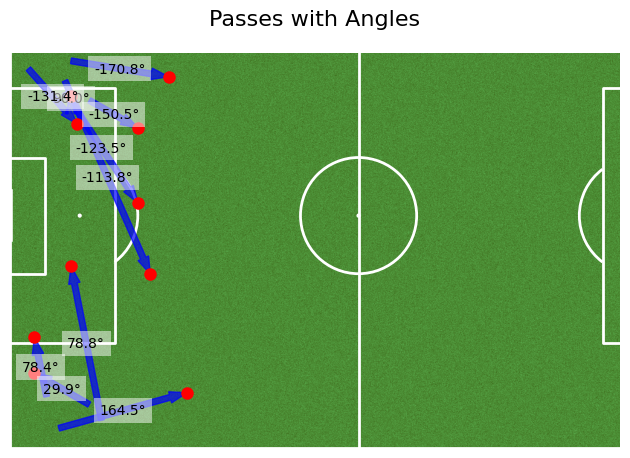

In [68]:
plot_passes_with_annotation(
    df=df_wing_passes,               # DataFrame containing the pass data
    num_samples=10,                  # Number of samples to plot
    annotation_col='pass_angle_deg', # Column with pass angles
    annotation_label='°',            # Degree symbol for angles
    plot_title='Passes with Angles', # Title for the plot
    x_col='x0', y_col='y0',          # Starting coordinates (x0, y0)
    x1_col='x1', y1_col='y1',        # Ending coordinates (x1, y1)
    marker_color='red',              # Color of the marker at the end of the pass
    marker_size=8,                   # Size of the marker
    arrow_color='blue',              # Color of the pass lines
    arrow_alpha=0.7,                 # Transparency of the pass lines
    arrow_width=1,                   # Width of the pass lines
    annotate_midpoint=True           # Annotate at the midpoint of the pass
)

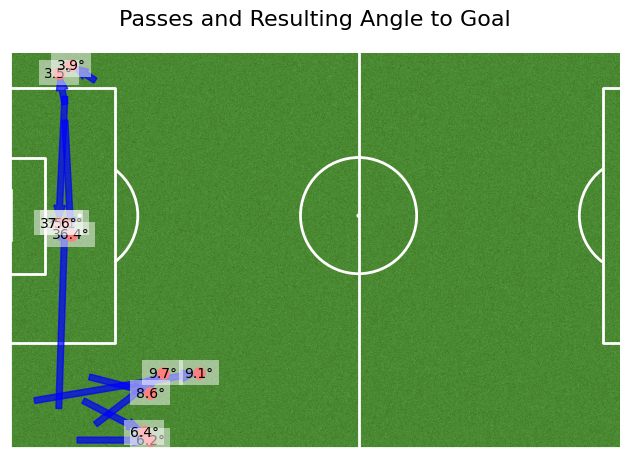

In [69]:
plot_passes_with_annotation(
    df=df_wing_passes, 
    num_samples=10, 
    annotation_col='goal_angle_deg', 
    annotation_label='°', 
    plot_title='Passes and Resulting Angle to Goal', 
    x_col='x0', y_col='y0', x1_col='x1', y1_col='y1', 
    marker_color='red', marker_size=8, 
    arrow_color='blue', arrow_alpha=0.7, arrow_width=1, 
    annotate_midpoint=False
)

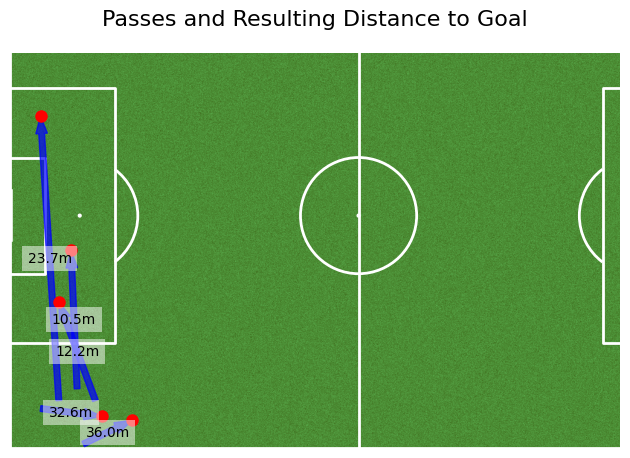

In [71]:
plot_passes_with_annotation(
    df=df_wing_passes, 
    num_samples=5, 
    annotation_col='distance_to_goal', 
    annotation_label='m', 
    plot_title='Passes and Resulting Distance to Goal', 
    x_col='x0', y_col='y0', x1_col='x1', y1_col='y1', 
    marker_color='red', marker_size=8, 
    arrow_color='blue', arrow_alpha=0.7, arrow_width=1, 
    annotate_midpoint=True
)

### Summary of Dataset

In [78]:
df_wing_passes_train = df_wing_passes[df_wing_passes['is_test'] == 0]
df_wing_passes_test = df_wing_passes[df_wing_passes['is_test'] == 1]

In [79]:
#Rule of thumb is to have 10x values of 0s and 1's per feature. 

for frame in [df_wing_passes_test, df_wing_passes_train]:
    print(f'sample size: {len(frame)}')
    zero_count = frame['shot_within_3_actions'].eq(0).sum()
    one_count = frame['shot_within_3_actions'].eq(1).sum()
    # Output the results
    print(f" Count of 0: {zero_count}")
    print(f" Count of 1: {one_count}")

sample size: 4434
 Count of 0: 3541
 Count of 1: 893
sample size: 6803
 Count of 0: 5652
 Count of 1: 1151


### Visualise Passes

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3066552948.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["X"] = 105 - df['x0']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3066552948.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Y"] = df['y0']


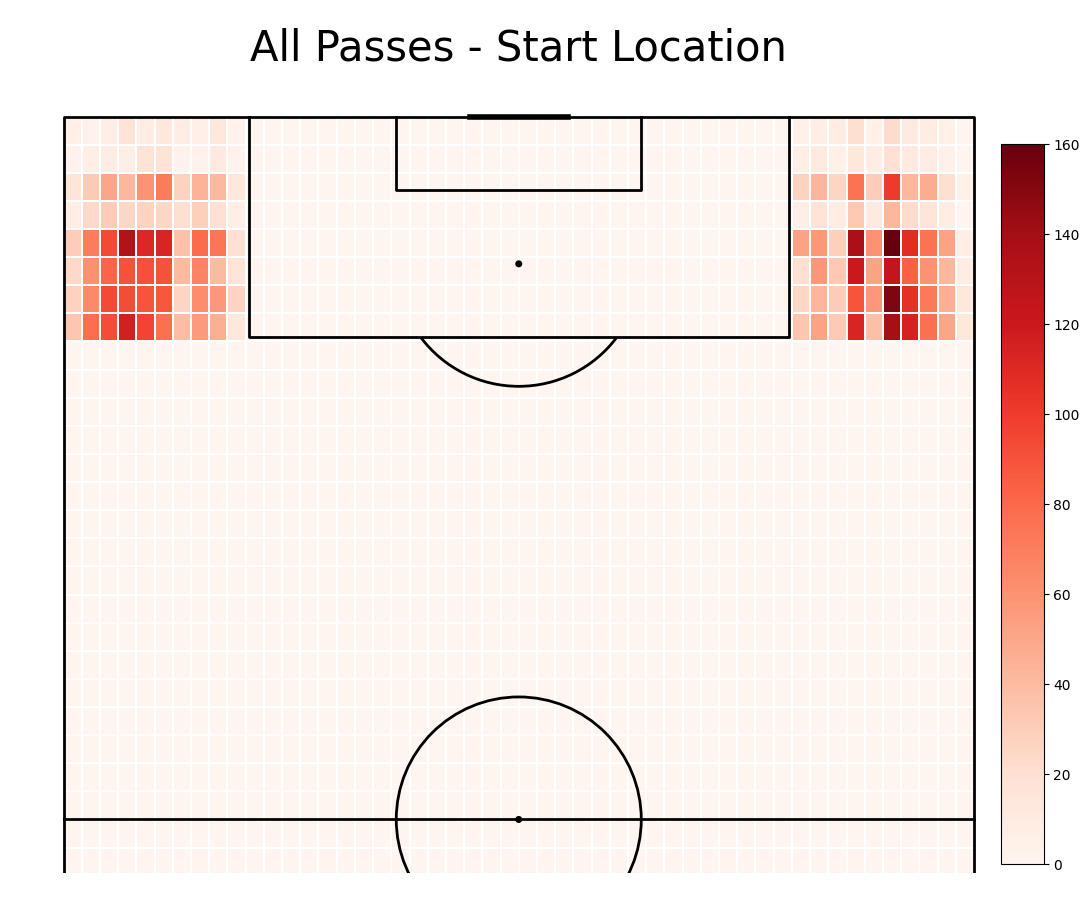

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3066552948.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_passes_shot_3_actions["X"] = 105 - df_passes_shot_3_actions['x1']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3066552948.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_passes_shot_3_actions["Y"] = df_passes_shot_3_actions['y1']


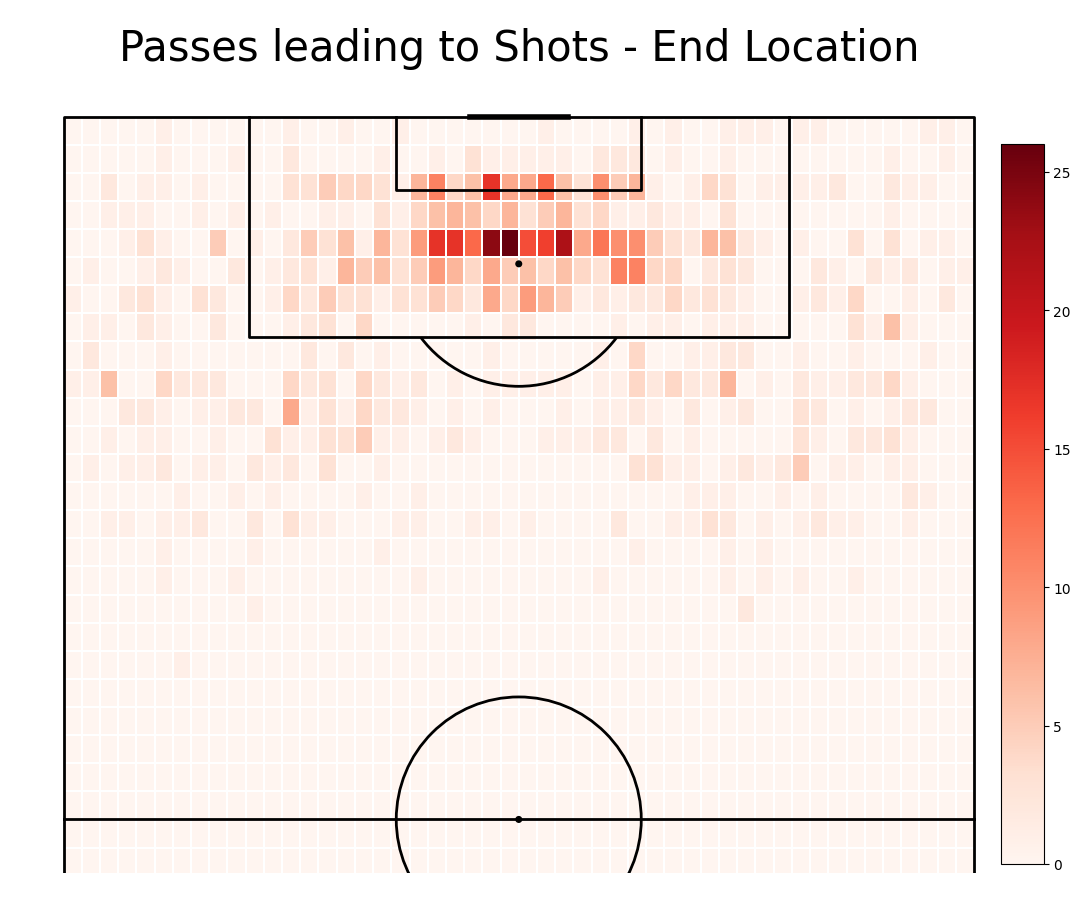

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3066552948.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_passes_no_shot_3_actions["X"] = 105 - df_passes_no_shot_3_actions['x1']
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3066552948.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_passes_no_shot_3_actions["Y"] = df_passes_no_shot_3_actions['y1']


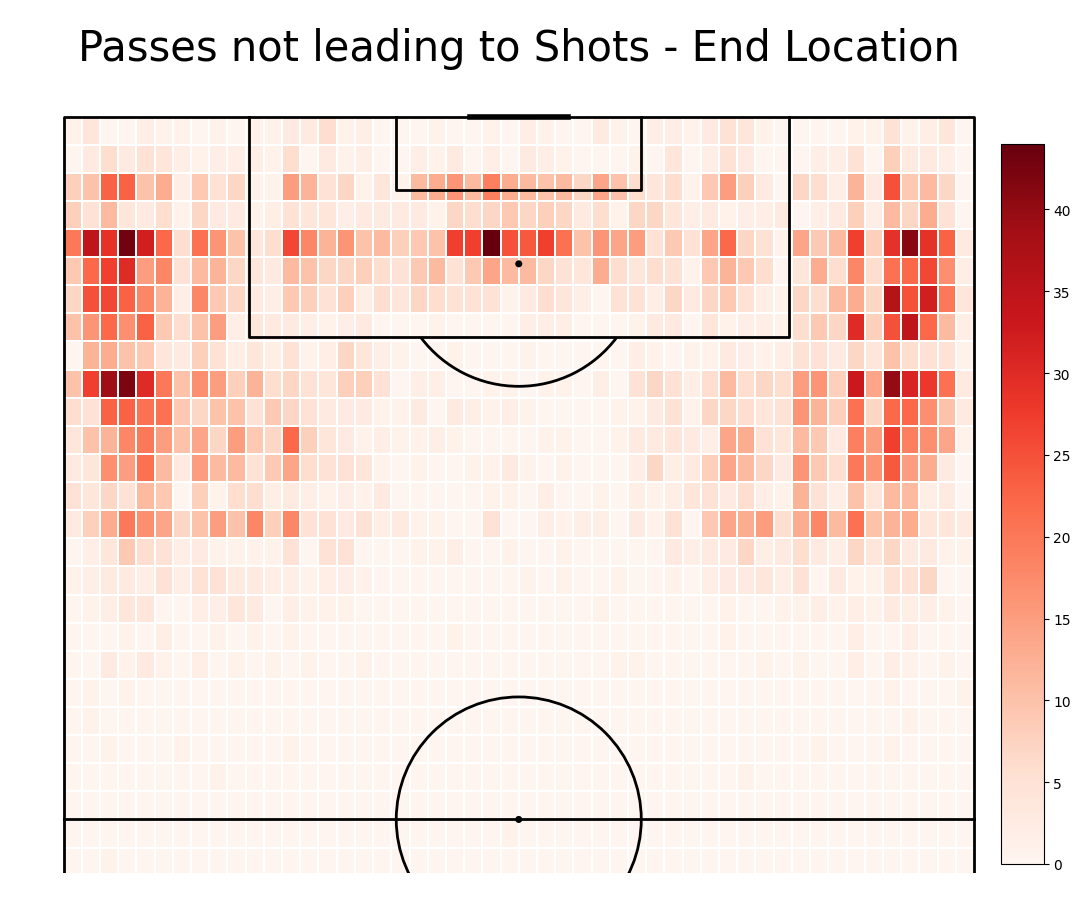

In [106]:
def plot_pass_locations(df, action_type='start'):
    """
    Plots pass locations on a soccer pitch based on the specified action type.

    Parameters:
    - df: DataFrame containing pass data.
    - action_type: Type of action to plot ('start' for start locations, 
                    'end_shot' for end locations leading to shots, 
                    'end_no_shot' for end locations not leading to shots).
    """

    pitch = VerticalPitch(line_color='black', half=True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)

    if action_type == 'start':
        # Get shot coordinates as separate columns for start locations
        df["X"] = 105 - df['x0']
        df["Y"] = df['y0'] 
        title = 'All Passes - Start Location'
        
        # Calculate number of passes in each bin
        bin_statistic_passes = pitch.bin_statistic(105 - df.X, df.Y, bins=50)

    elif action_type == 'end_shot':
        # Filter DataFrame for passes leading to shots
        df_passes_shot_3_actions = df[df['shot_within_3_actions'] == 1]
        df_passes_shot_3_actions["X"] = 105 - df_passes_shot_3_actions['x1']
        df_passes_shot_3_actions["Y"] = df_passes_shot_3_actions['y1'] 
        title = 'Passes leading to Shots - End Location'
        
        # Calculate number of shots in each bin
        bin_statistic_passes = pitch.bin_statistic(105 - df_passes_shot_3_actions.X, df_passes_shot_3_actions.Y, bins=50)

    elif action_type == 'end_no_shot':
        # Filter DataFrame for passes not leading to shots
        df_passes_no_shot_3_actions = df[df['shot_within_3_actions'] == 0]
        df_passes_no_shot_3_actions["X"] = 105 - df_passes_no_shot_3_actions['x1']
        df_passes_no_shot_3_actions["Y"] = df_passes_no_shot_3_actions['y1'] 
        title = 'Passes not leading to Shots - End Location'
        
        # Calculate number of passes in each bin
        bin_statistic_passes = pitch.bin_statistic(105 - df_passes_no_shot_3_actions.X, df_passes_no_shot_3_actions.Y, bins=50)

    else:
        raise ValueError("Invalid action_type. Use 'start', 'end_shot', or 'end_no_shot'.")

    # Make heatmap
    pcm = pitch.heatmap(bin_statistic_passes, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth=0.01)

    # Make legend
    ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    fig.suptitle(title, fontsize=30)
    plt.show()

# Example usage:
# To plot start locations:
plot_pass_locations(df_wing_passes_train, action_type='start')

# To plot end locations leading to shots:
plot_pass_locations(df_wing_passes_train, action_type='end_shot')

# To plot end locations not leading to shots:
plot_pass_locations(df_wing_passes_train, action_type='end_no_shot')


### Parameter Estimation: Finding Relationships to our Target Variable

In [110]:
df_wing_passes_shot_3_actions = df_wing_passes_train[df_wing_passes_train['shot_within_3_actions'] == 1]

In [111]:
def feature_correlation(target, range, title):
    # number of passes on angle
    shotcount_dist = np.histogram(df_wing_passes_train[target], bins=100, range=range)
    # number of passes leading to shots from angle
    goalcount_dist = np.histogram(df_wing_passes_shot_3_actions[target], bins=100, range=range)
    
    # Handle division and invalid errors
    np.seterr(divide='ignore', invalid='ignore')
    # Probability of scoring goal
    prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
    angle = shotcount_dist[1]
    midangle = (angle[:-1] + angle[1:]) / 2
    
    # Create and fit the model
    formula = f"shot_within_3_actions ~ {target}"
    test_model = smf.glm(formula=formula, data=df_wing_passes_train, family=sm.families.Binomial()).fit()
    
    # Print summary for inspection
    print(test_model.summary())
    
    # Get predicted probabilities from the model
    df_temp = pd.DataFrame({target: midangle})
    predicted_probs = test_model.predict(df_temp)
    
    # Make plot
    fig, ax = plt.subplots()
    
    # Plot actual data (probability of goal per angle)
    ax.plot(midangle, prob_goal, linestyle='none', marker='.', markersize=12, color='black')
    
    # Set labels
    ax.set_ylabel('Probability Shot Happened')
    ax.set_xlabel(title)
    
    # Plot line of best fit from model's predictions
    ax.plot(midangle, predicted_probs, linestyle='solid', color='black')
    
    # Remove unnecessary spines for cleaner plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -3092.6
Date:                   Sat, 19 Oct 2024   Deviance:                       6185.2
Time:                           11:46:35   Pearson chi2:                 6.80e+03
No. Iterations:                        4   Pseudo R-squ. (CS):          1.039e-05
Covariance Type:               nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

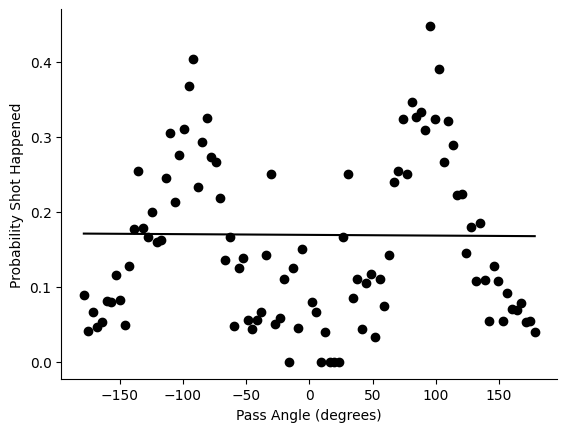

In [115]:
feature_correlation('pass_angle_deg', [-180, 180], "Pass Angle (degrees)")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -3026.1
Date:                   Sat, 19 Oct 2024   Deviance:                       6052.1
Time:                           11:47:38   Pearson chi2:                 6.62e+03
No. Iterations:                        5   Pseudo R-squ. (CS):            0.01939
Covariance Type:               nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

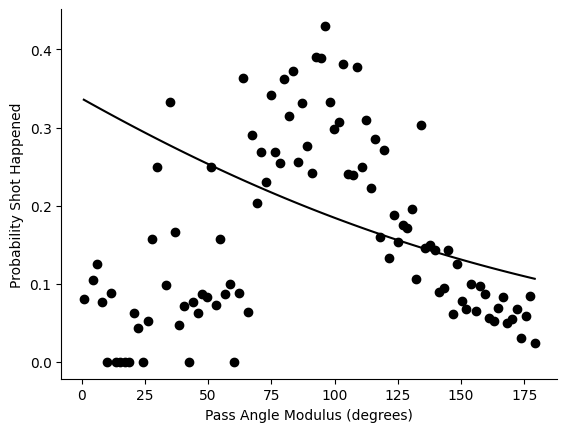

In [117]:
feature_correlation('pass_angle_deg_mod', [0, 180], "Pass Angle Modulus (degrees)")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -2970.0
Date:                   Sat, 19 Oct 2024   Deviance:                       5940.1
Time:                           11:45:09   Pearson chi2:                 6.60e+03
No. Iterations:                        5   Pseudo R-squ. (CS):            0.03540
Covariance Type:               nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercep

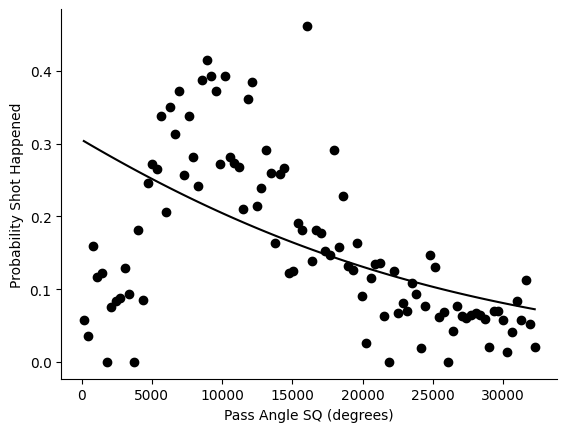

In [112]:
feature_correlation('pass_angle_deg_sq', [0, 32400], "Pass Angle SQ (degrees)")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -2610.0
Date:                   Sat, 19 Oct 2024   Deviance:                       5219.9
Time:                           11:45:44   Pearson chi2:                 6.76e+03
No. Iterations:                        6   Pseudo R-squ. (CS):             0.1323
Covariance Type:               nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0902 

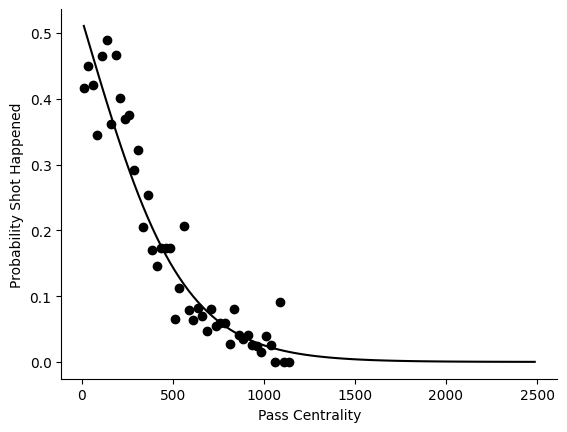

In [113]:
feature_correlation('c0c1', [0, 2500], "Pass Centrality")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -2971.9
Date:                   Sat, 19 Oct 2024   Deviance:                       5943.8
Time:                           11:48:38   Pearson chi2:                 6.52e+03
No. Iterations:                        5   Pseudo R-squ. (CS):            0.03487
Covariance Type:               nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.32

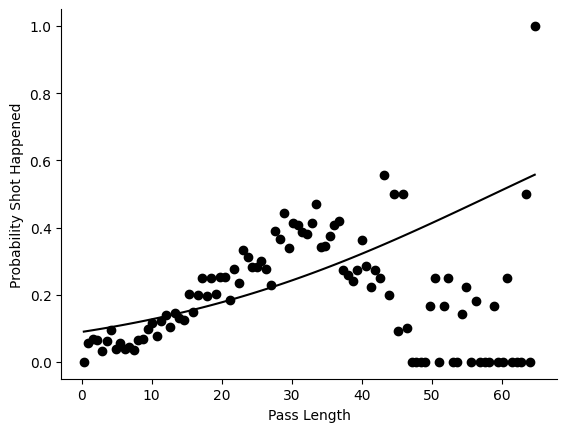

In [118]:
feature_correlation('pass_length', [0, 65], "Pass Length")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -2679.9
Date:                   Sat, 19 Oct 2024   Deviance:                       5359.7
Time:                           11:49:40   Pearson chi2:                 1.57e+04
No. Iterations:                        5   Pseudo R-squ. (CS):             0.1143
Covariance Type:               nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept 

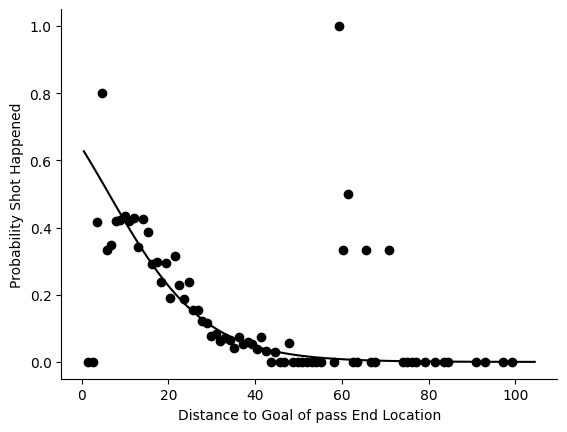

In [120]:
feature_correlation('distance_to_goal', [0, 105], "Distance to Goal of pass End Location")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -2783.8
Date:                   Sat, 19 Oct 2024   Deviance:                       5567.6
Time:                           11:50:01   Pearson chi2:                 6.66e+03
No. Iterations:                        5   Pseudo R-squ. (CS):            0.08679
Covariance Type:               nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     

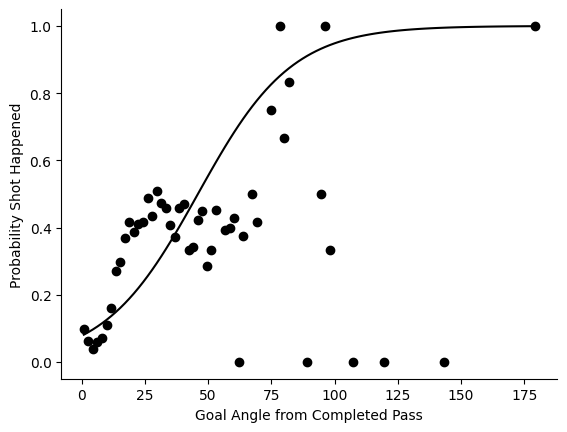

In [121]:
feature_correlation('goal_angle_deg', [0, 180], "Goal Angle from Completed Pass")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -2805.1
Date:                   Sat, 19 Oct 2024   Deviance:                       5610.1
Time:                           11:50:35   Pearson chi2:                 6.80e+03
No. Iterations:                        5   Pseudo R-squ. (CS):            0.08107
Covariance Type:               nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2

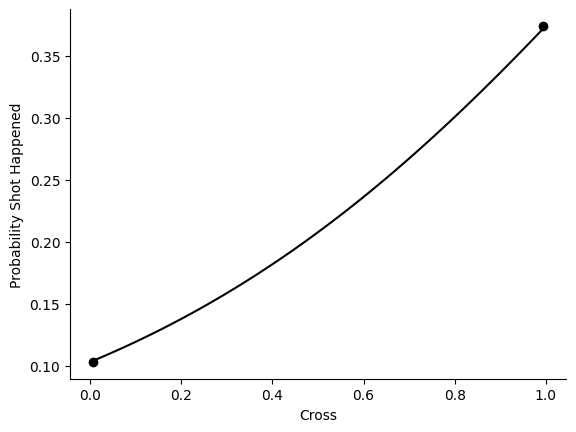

In [122]:
feature_correlation('Cross_metric', [0, 1], "Cross")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -3089.9
Date:                   Sat, 19 Oct 2024   Deviance:                       6179.8
Time:                           11:50:57   Pearson chi2:                 6.80e+03
No. Iterations:                        5   Pseudo R-squ. (CS):          0.0007998
Covariance Type:               nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept 

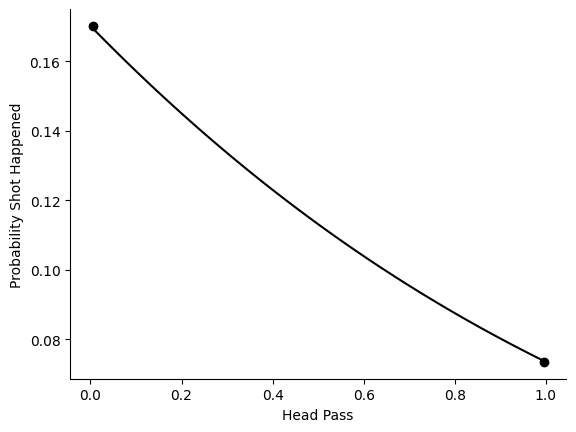

In [123]:
feature_correlation('Head_pass_metric', [0, 1], "Head Pass")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -3090.7
Date:                   Sat, 19 Oct 2024   Deviance:                       6181.5
Time:                           11:51:14   Pearson chi2:                 6.80e+03
No. Iterations:                        4   Pseudo R-squ. (CS):          0.0005592
Covariance Type:               nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercep

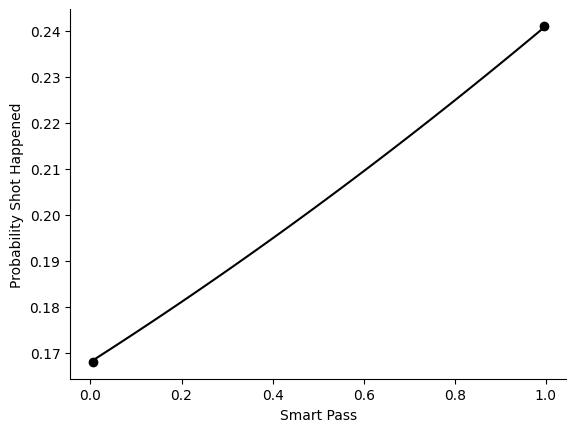

In [124]:
feature_correlation('Smart_pass_metric', [0, 1], "Smart Pass")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -3092.6
Date:                   Sat, 19 Oct 2024   Deviance:                       6185.2
Time:                           11:51:29   Pearson chi2:                 6.80e+03
No. Iterations:                        4   Pseudo R-squ. (CS):          1.596e-05
Covariance Type:               nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept 

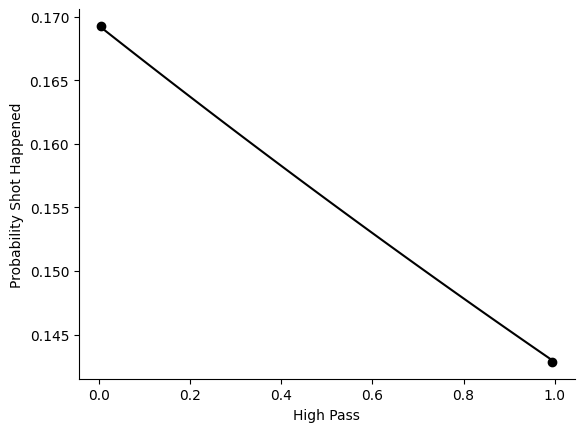

In [125]:
feature_correlation('High_pass_metric', [0, 1], "High Pass")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -3092.6
Date:                   Sat, 19 Oct 2024   Deviance:                       6185.1
Time:                           11:51:58   Pearson chi2:                 6.80e+03
No. Iterations:                        4   Pseudo R-squ. (CS):          2.619e-05
Covariance Type:               nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

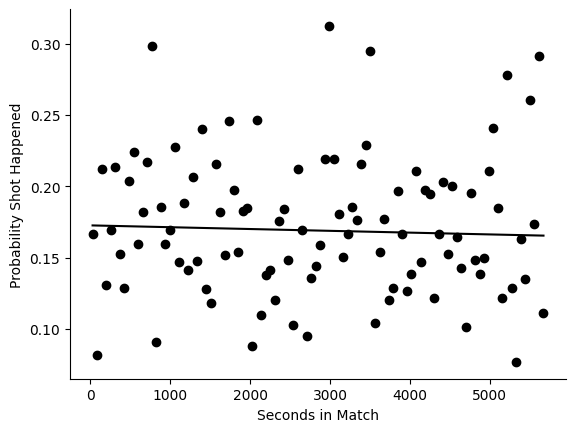

In [127]:
feature_correlation('seconds_of_game_elapsed', [0, 5700], "Seconds in Match")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -3092.6
Date:                   Sat, 19 Oct 2024   Deviance:                       6185.2
Time:                           11:52:09   Pearson chi2:                 6.80e+03
No. Iterations:                        4   Pseudo R-squ. (CS):          1.450e-05
Covariance Type:               nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

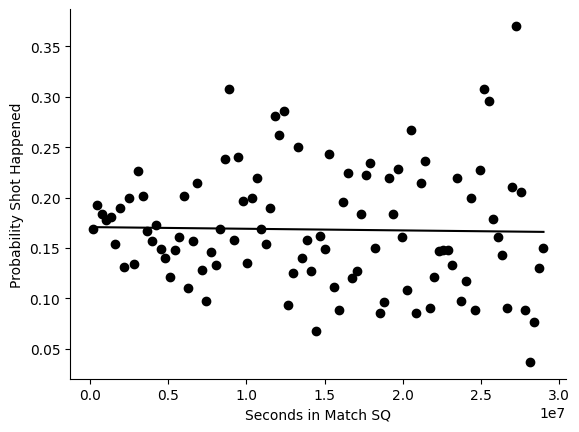

In [128]:
feature_correlation('seconds_of_game_elapsed_sq', [0, 29160000], "Seconds in Match SQ")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -3091.0
Date:                   Sat, 19 Oct 2024   Deviance:                       6182.0
Time:                           12:11:59   Pearson chi2:                 6.80e+03
No. Iterations:                        4   Pseudo R-squ. (CS):          0.0004830
Covariance Type:               nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9907 

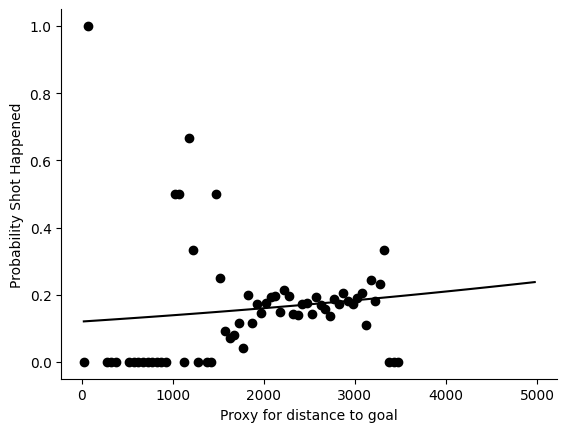

In [149]:
feature_correlation('x1c0', [0, 5000], "Proxy for distance to goal")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -2993.8
Date:                   Sat, 19 Oct 2024   Deviance:                       5987.7
Time:                           12:12:41   Pearson chi2:                 7.03e+03
No. Iterations:                        5   Pseudo R-squ. (CS):            0.02863
Covariance Type:               nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5623 

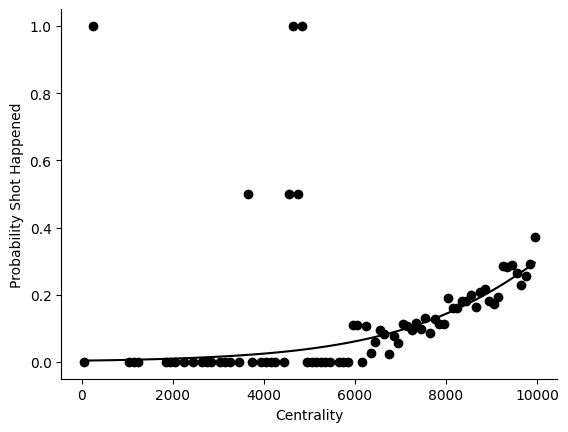

In [153]:
feature_correlation('x0x1', [0, 100**2], "Centrality")

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 6803
Model:                               GLM   Df Residuals:                     6801
Model Family:                   Binomial   Df Model:                            1
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -3042.0
Date:                   Sat, 19 Oct 2024   Deviance:                       6084.0
Time:                           12:16:30   Pearson chi2:                 6.81e+03
No. Iterations:                        5   Pseudo R-squ. (CS):            0.01477
Covariance Type:               nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1082 

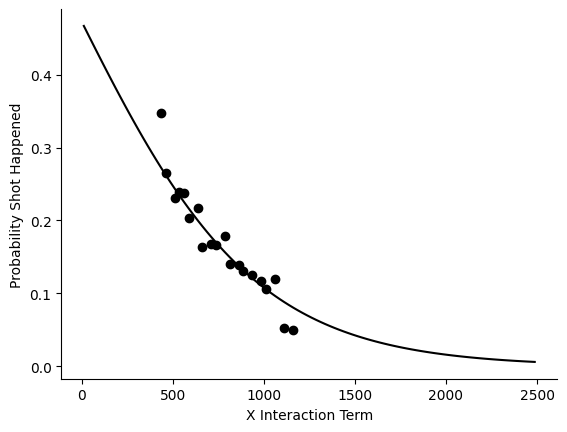

In [172]:
feature_correlation('c0c0', [0, 50**2], "X Interaction Term")

### Fitting Logistic Regression Model

In [176]:
selected_model_variables = ['Smart_pass_metric', 'Cross_metric', 'distance_to_goal', 'goal_angle_deg', 'c0c0', 'c0c1', 'x1c1', 'pass_angle_deg']

from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import numpy as np
import statsmodels.api as sm

def fit_and_calculate_xWideThreat(df, model_variables, threshold=0.5):
    """
    Fits a logistic regression model on training data, and calculates both the probability (xWideThreat_Linear) 
    and binary outcome (0 or 1) for each pass.
    
    Parameters:
    - df: DataFrame containing the pass data.
    - model_variables: List of variable names to include in the model.
    - threshold: The threshold for converting predicted probabilities to binary outcome (default is 0.5).
    
    Returns:
    - df: The input DataFrame with two additional columns: 
          'xWideThreat_Linear' (predicted probabilities) and 'xWideThreat_Binary' (binary outcome).
    """
    
    # Split the data into train and validation sets
    train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)  # 80% train, 20% validation
    
    # Build the formula for the logistic regression model
    model_formula = 'shot_within_3_actions ~ ' + ' + '.join(model_variables)
    
    # Fit the logistic regression model on training data
    test_model = smf.glm(formula=model_formula, data=train_df,
                         family=sm.families.Binomial()).fit()
    
    # Print model summary
    print(test_model.summary())
    
    # Extract the model parameters (coefficients)
    b = test_model.params
    
    # Define a function to calculate xWideThreat_Linear (predicted probability) for each row
    def calculate_xWideThreat(sh):
        bsum = b[0]  # Intercept
        for i, v in enumerate(model_variables):
            bsum += b[i + 1] * sh[v]
        xWideThreat_Linear = 1 / (1 + np.exp(-bsum))
        return xWideThreat_Linear
    
    # Apply the function to both training and validation sets
    df['xWideThreat_Linear'] = df.apply(calculate_xWideThreat, axis=1)
    
    # Calculate the binary outcome (0 or 1) based on the threshold for both training and validation sets
    df['xWideThreat_Binary'] = (df['xWideThreat_Linear'] >= threshold).astype(int)
    
    return df, test_model, validation_df

# Example usage:
df_wing_passes_train, test_model, validation_df = fit_and_calculate_xWideThreat(df_wing_passes_train, selected_model_variables)




                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 5442
Model:                               GLM   Df Residuals:                     5433
Model Family:                   Binomial   Df Model:                            8
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -2065.9
Date:                   Sat, 19 Oct 2024   Deviance:                       4131.8
Time:                           12:35:58   Pearson chi2:                 5.41e+03
No. Iterations:                        6   Pseudo R-squ. (CS):             0.1379
Covariance Type:               nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercep

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3602244130.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsum = b[0]  # Intercept
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3602244130.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsum += b[i + 1] * sh[v]
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3602244130.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

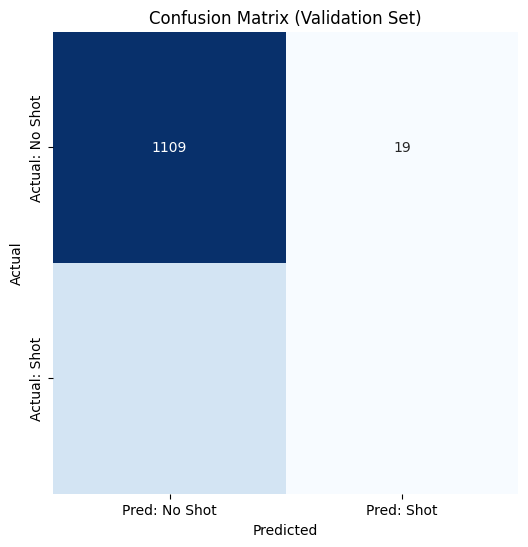

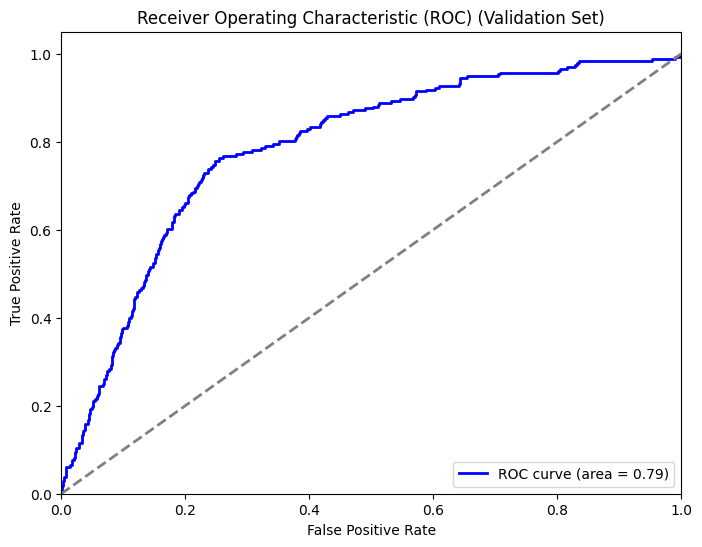

ROC-AUC Score (Validation Set): 0.7871

Performance Summary (Validation Set):
Accuracy: 0.8273
Precision: 0.4722
Recall: 0.0730
F1 Score: 0.1264

Classification Report (Validation Set):
              precision    recall  f1-score   support

     No Shot       0.84      0.98      0.90      1128
        Shot       0.47      0.07      0.13       233

    accuracy                           0.83      1361
   macro avg       0.65      0.53      0.52      1361
weighted avg       0.77      0.83      0.77      1361



In [177]:
def assess_model_performance(validation_df, true_col, pred_col, plot_roc=True):
    """
    Assesses the performance of the model by generating a confusion matrix, ROC-AUC curve,
    and printing accuracy, precision, recall, f1 score, and a classification report.

    Parameters:
    - validation_df: DataFrame containing the true values and predicted probabilities or binary outcomes for validation.
    - true_col: The name of the column containing the true values (ground truth).
    - pred_col: The name of the column containing the predicted values (probabilities or binary outcomes).
    - plot_roc: Whether to plot the ROC curve (default is True).

    Returns:
    - None (plots confusion matrix and ROC-AUC curve, prints metrics).
    """

    # Step 1: Generate Confusion Matrix
    y_true = validation_df[true_col]
    y_pred = validation_df[pred_col]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=['Actual: No Shot', 'Actual: Shot'], columns=['Pred: No Shot', 'Pred: Shot'])

    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title('Confusion Matrix (Validation Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Step 2: Calculate ROC-AUC
    if plot_roc:
        fpr, tpr, _ = roc_curve(y_true, validation_df['xWideThreat_Linear'])
        roc_auc = auc(fpr, tpr)

        # Plot ROC Curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) (Validation Set)')
        plt.legend(loc="lower right")
        plt.show()

        # Print ROC-AUC score
        print(f"ROC-AUC Score (Validation Set): {roc_auc:.4f}")

    # Step 3: Calculate additional performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\nPerformance Summary (Validation Set):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Step 4: Print classification report (detailed metrics for each class)
    print("\nClassification Report (Validation Set):")
    print(classification_report(y_true, y_pred, target_names=['No Shot', 'Shot']))


assess_model_performance(validation_df, 'shot_within_3_actions', 'xWideThreat_Binary')

### Optimise Parameters

Find the correlation between predictors

In [188]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

def assess_model_features(df, model_variables, target_variable='shot_within_3_actions', test_size=0.2, random_state=42):
    """
    This function performs a series of tasks:
    1. Splits the data into training and validation sets.
    2. Checks for multicollinearity using Variance Inflation Factor (VIF).
    3. Scales the features.
    4. Performs cross-validation with Logistic Regression and reports the average AUC-ROC.
    5. Fits a Logistic Regression model with L1 regularization (lasso) to find the zeroed-out features.
    6. Performs Recursive Feature Elimination (RFE) to select the most important features.

    Parameters:
    - df: DataFrame containing the pass data.
    - model_variables: List of predictor variables to be used for model training.
    - target_variable: The column name of the target variable (default is 'shot_within_3_actions').
    - test_size: Proportion of the data to be used for the validation set (default is 0.2).
    - random_state: Random seed for reproducibility (default is 42).
    
    Returns:
    - vif_data: DataFrame showing the VIF for each feature.
    - selected_features: List of selected features based on RFE.
    """
    
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(df[model_variables], df[target_variable], 
                                                      test_size=test_size, random_state=random_state)
    
    # Check VIF for multicollinearity
    vif_data = pd.DataFrame()
    vif_data["feature"] = model_variables
    vif_data["VIF"] = [variance_inflation_factor(X_train[model_variables].values, i) for i in range(len(model_variables))]
    
    print("VIF Data:")
    print(vif_data)
    
    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Perform cross-validation with Logistic Regression (AUC-ROC score)
    log_model = LogisticRegression(max_iter=1000)
    cv_scores = cross_val_score(log_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    print(f"\nAverage AUC-ROC from cross-validation: {cv_scores.mean():.4f}")

    # Fit Logistic Regression with L1 Regularization (Lasso)
    log_model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000)
    log_model_l1.fit(X_train_scaled, y_train)
    
    print("\nL1 Regularization (Lasso) Coefficients:")
    print(f"Coefficients: {log_model_l1.coef_}")
    
    # Recursive Feature Elimination (RFE) to select top 10 features
    rfe = RFE(log_model, n_features_to_select=10)  # Select the top 10 features
    rfe = rfe.fit(X_train_scaled, y_train)
    
    # Get the selected features based on RFE
    selected_features = [model_variables[i] for i in range(len(rfe.support_)) if rfe.support_[i]]
    
    print("\nSelected Features (RFE):")
    print(selected_features)
    
    return vif_data, selected_features


In [193]:
all_model_variables = ['x0',
       'c0', 'x1', 'c1', 'y0', 'y1',
       'x0x0', 'x0x1', 'x0c0', 'x0c1', 'x1x1', 'x1c0', 'x1c1', 'c0c0', 'c0c1',
       'c1c1', 'x0x0x0', 'x0x0x1', 'x0x0c0', 'x0x0c1', 'x0x1x1', 'x0x1c0',
       'x0x1c1', 'x0c0c0', 'x0c0c1', 'x0c1c1', 'x1x1x1', 'x1x1c0', 'x1x1c1',
       'x1c0c0', 'x1c0c1', 'x1c1c1', 'c0c0c0', 'c0c0c1', 'c0c1c1', 'c1c1c1',
       'pass_length', 'pass_angle_deg', 'pass_angle_deg_sq',
       'pass_angle_deg_mod', 'goal_angle_deg', 'distance_to_goal',
       'adjusted_eventSec', 'seconds_of_game_elapsed',
       'seconds_of_game_elapsed_sq', 'Simple_pass_metric', 'Cross_metric',
       'Head_pass_metric', 'Smart_pass_metric', 'High_pass_metric']

In [208]:
vif_data, optimised_features = assess_model_features(df_wing_passes_train, all_model_variables)

VIF Data:
                       feature           VIF
0                           x0  2.703435e+06
1                           c0  5.487468e+05
2                           x1  4.365763e+05
3                           c1  4.134886e+05
4                           y0  3.996026e+00
5                           y1  3.168199e+00
6                         x0x0  9.950324e+06
7                         x0x1  1.873941e+06
8                         x0c0  1.481156e+06
9                         x0c1  1.230933e+06
10                        x1x1  4.000455e+04
11                        x1c0  1.367869e+05
12                        x1c1  6.349006e+04
13                        c0c0  3.888519e+05
14                        c0c1  9.975677e+04
15                        c1c1  2.018048e+04
16                      x0x0x0  2.484190e+06
17                      x0x0x1  6.332694e+05
18                      x0x0c0  4.448791e+05
19                      x0x0c1  2.883389e+05
20                      x0x1x1  2.543450e+04


Re run the fit and validation on the new selected features

In [217]:
#Remove c1c1 and c1c1c1 as they were not significant 
optimised_features_dropped = ['x0', 'x1c1', 'c0c0', 'x0x0c0', 'x1x1x1', 'x1x1c1', 'x1c1c1', 'distance_to_goal']
df_wing_passes_train, test_model, validation_df = fit_and_calculate_xWideThreat(df_wing_passes_train, optimised_features_dropped)

                   Generalized Linear Model Regression Results                   
Dep. Variable:     shot_within_3_actions   No. Observations:                 5442
Model:                               GLM   Df Residuals:                     5433
Model Family:                   Binomial   Df Model:                            8
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -2058.9
Date:                   Sat, 19 Oct 2024   Deviance:                       4117.7
Time:                           13:18:12   Pearson chi2:                 5.59e+03
No. Iterations:                        6   Pseudo R-squ. (CS):             0.1401
Covariance Type:               nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept 

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3602244130.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsum = b[0]  # Intercept
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3602244130.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bsum += b[i + 1] * sh[v]
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/3602244130.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

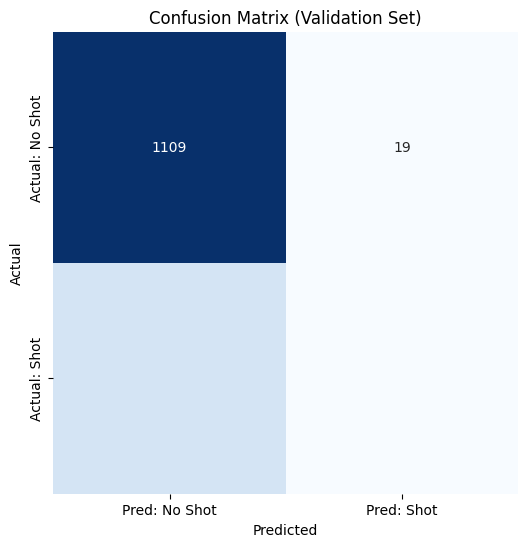

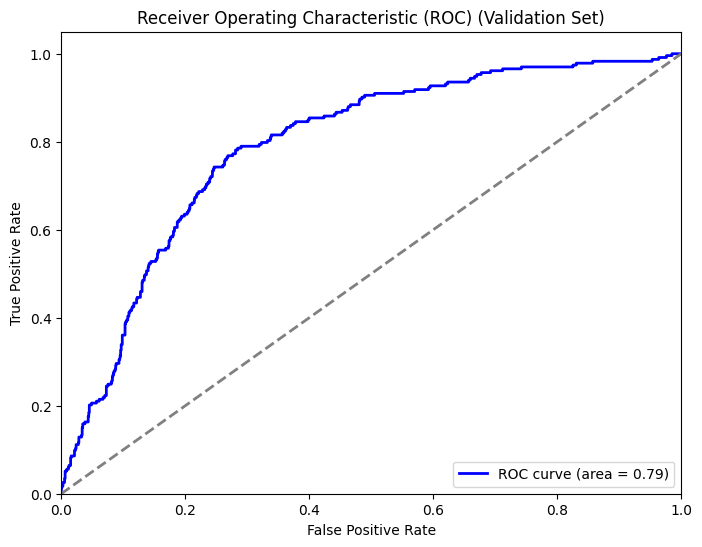

ROC-AUC Score (Validation Set): 0.7905

Performance Summary (Validation Set):
Accuracy: 0.8295
Precision: 0.5128
Recall: 0.0858
F1 Score: 0.1471

Classification Report (Validation Set):
              precision    recall  f1-score   support

     No Shot       0.84      0.98      0.91      1128
        Shot       0.51      0.09      0.15       233

    accuracy                           0.83      1361
   macro avg       0.68      0.53      0.53      1361
weighted avg       0.78      0.83      0.78      1361



In [218]:
assess_model_performance(validation_df, 'shot_within_3_actions', 'xWideThreat_Binary')

In [219]:
#Testing

#df_poss_chains = pd.DataFrame()
#for i in range(11):
#    file_name = 'possession_chains_England' + str(i+1) + '.json'
#    path = os.path.join(str(pathlib.Path().resolve()), 'data', 'Wyscout',  file_name)
#    with open(path) as f:
#        data = json.load(f)
#    df_poss_chains = pd.concat([df_poss_chains, pd.DataFrame(data)], ignore_index = True)
#df_poss_chains = df_poss_chains.reset_index()
#
#df_poss_chains = df_poss_chains.drop(columns='level_0')

#assert (df.values == df_poss_chains.values).all()
#assert np.allclose(df.values, df_poss_chains.values)

### Fitting XGBoost Model

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier

def assess_xgboost_model(df, model_variables, target_variable='shot_within_3_actions', test_size=0.2, random_state=123):
    """
    This function performs XGBoost model evaluation including:
    1. Data splitting into training and test sets.
    2. Cross-validation to evaluate the model's performance.
    3. Model fitting and performance evaluation on both training and test sets.
    4. Confusion matrix visualization.
    5. Classification report (precision, recall, F1-score).
    6. ROC curve and AUC calculation.

    Parameters:
    - df: DataFrame containing the pass data.
    - model_variables: List of predictor variables.
    - target_variable: The column name of the target variable (default is 'shot_within_3_actions').
    - test_size: Proportion of the data to be used for the test set (default is 0.1).
    - random_state: Random seed for reproducibility (default is 123).
    
    Returns:
    - None (prints and plots the results).
    """
    
    # Define the features (X) and target variable (y)
    X = df[model_variables].values
    y = df[target_variable].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

    # Initialize the XGBoost Classifier with specified hyperparameters
    ratio = len(df[df[target_variable] == 0]) / len(df[df[target_variable] == 1])
    print(f"Class imbalance ratio (No Shot : Shot): {ratio:.4f}")
    
    xgb = XGBClassifier(n_estimators=100, max_depth=4, random_state=random_state, scale_pos_weight=ratio)
    
    # Perform 10-fold cross-validation on the training set
    print("\nPerforming 10-fold cross-validation...")
    scores = cross_val_score(estimator=xgb, X=X_train, y=y_train, cv=10, n_jobs=-1)
    
    print(f"Mean cross-validation score: {np.mean(scores):.4f}")
    print(f"Standard deviation of cross-validation scores: {np.std(scores):.4f}")
    
    # Fit the model to the training data
    print("\nFitting the model to the training data...")
    xgb.fit(X_train, y_train)
    
    # Training set performance (accuracy)
    train_score = xgb.score(X_train, y_train)
    print(f"\nTraining set accuracy: {train_score:.4f}")
    
    # Predict on the test set
    y_pred = xgb.predict(X_test)
    
    # Test set performance (accuracy)
    test_score = xgb.score(X_test, y_test)
    print(f"Test set accuracy: {test_score:.4f}")

    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Shot", "Shot"], yticklabels=["No Shot", "Shot"])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Optional: Classification report (precision, recall, F1-score)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["No Shot", "Shot"]))
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"\nROC AUC Score: {roc_auc:.4f}")
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    return xgb


Training set size: 5442
Test set size: 1361
Class imbalance ratio (No Shot : Shot): 4.9105

Performing 10-fold cross-validation...
Mean cross-validation score: 0.7398
Standard deviation of cross-validation scores: 0.0132

Fitting the model to the training data...

Training set accuracy: 0.8324
Test set accuracy: 0.7303

Confusion Matrix:
[[862 269]
 [ 98 132]]


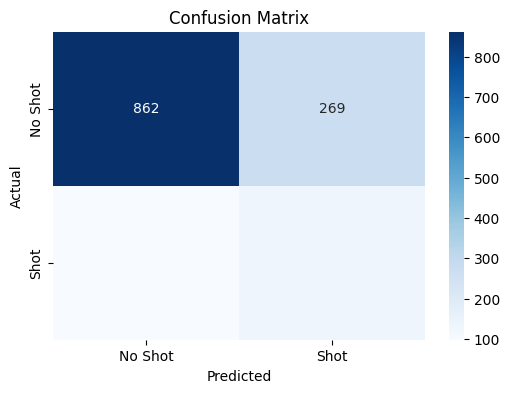


Classification Report:
              precision    recall  f1-score   support

     No Shot       0.90      0.76      0.82      1131
        Shot       0.33      0.57      0.42       230

    accuracy                           0.73      1361
   macro avg       0.61      0.67      0.62      1361
weighted avg       0.80      0.73      0.76      1361


ROC AUC Score: 0.6680


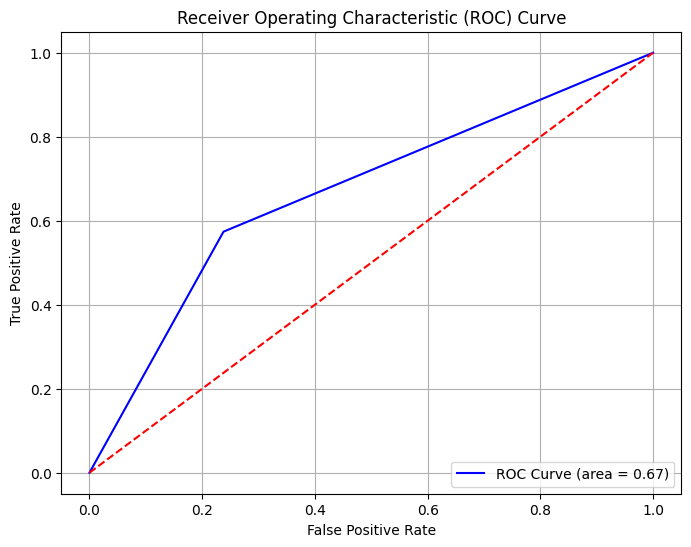

In [221]:
xgb_model = assess_xgboost_model(df_wing_passes_train, optimised_features)

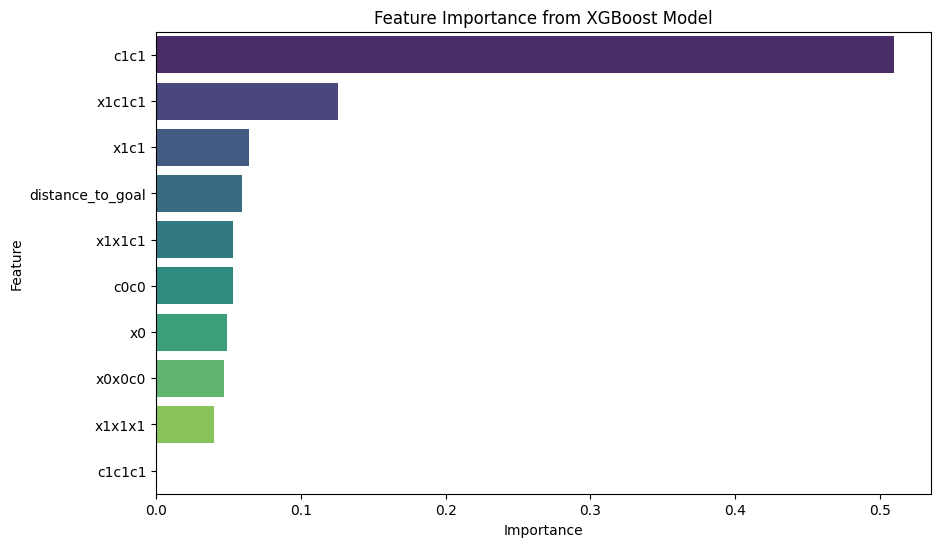

In [222]:
def plot_xgboost_feature_importance(xgb_model, model_variables):
    """
    This function visualizes the feature importance from an XGBoost model.
    
    Parameters:
    - xgb_model: Fitted XGBoost model.
    - model_variables: List of feature names.
    
    Returns:
    - None (displays the feature importance plot).
    """
    # Get feature importance from the XGBoost model
    importance = xgb_model.feature_importances_

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({'Feature': model_variables, 'Importance': importance})

    # Sort the features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance from XGBoost Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Assuming xgb_model is your trained XGBoost model
plot_xgboost_feature_importance(xgb_model, optimised_features)

### Fit xG Model based on chosen features

In [223]:
from sklearn.linear_model import LinearRegression

def fit_xg(df, model_variables):
    """
    Fits a linear regression model for expected goals (xG) using shot-ended records from the training set.
    
    Parameters:
    - model: A trained machine learning model (e.g., XGBoost or similar). Not used in the function, 
             but kept here for consistency in the function signature.
    - df: DataFrame containing the training data with shot-ended records (used to fit the xG model).
    - model_variables: List of feature names used for xG prediction.
    
    Returns:
    - lr: A fitted Linear Regression model for xG prediction.
    """
    
    # Fit OLS model for xG calculation (only on the shot-ended records from the training set)
    shot_ended = df.loc[df["shot_within_3_actions"] == 1]
    X2 = shot_ended[model_variables].values
    y2 = shot_ended["xG"].values
    
    # Fit a linear regression model on the shot-ended data for xG prediction
    lr = LinearRegression()
    lr.fit(X2, y2)
    
    # Return the fitted Linear Regression model
    return lr

xg_model_fitted = fit_xg(df_wing_passes_train, optimised_features_dropped)

### Find the best Players in the PL

In [234]:
def calculate_shot_probabilities_and_xG(df, model, xg_model, feature_columns, target_column="shot_within_3_actions"):
    """
    This function predicts the probability of a shot occurring within 3 actions and calculates the expected goals (xG) 
    using the provided models. It then calculates the xWideThreat as the product of shot probability and predicted xG.
    
    Parameters:
    - df: DataFrame containing the data on which predictions will be made.
    - model: The fitted model used to predict the probability of a shot occurring within 3 actions (e.g., GLM or Logistic Regression).
    - xg_model: The fitted model used to predict expected goals (xG).
    - feature_columns: List of feature column names to be used for making predictions.
    - target_column: The name of the column that represents whether a shot occurred (default is 'shot_within_3_actions').
    
    Returns:
    - df: The updated DataFrame with new columns for shot probabilities, predicted xG, and xWideThreat.
    """
    
    # Extract features for the new league from the DataFrame
    X_new_league = df[feature_columns]
    
    # Predict the probability of a shot occurring within 3 actions
    y_pred_proba = model.predict(X_new_league)
    df["shot_3_actions_prob"] = y_pred_proba
    
    # Predict the expected goals (xG) using the xG model
    y_pred_xg = xg_model.predict(X_new_league)
    df["xG_pred"] = y_pred_xg
    
    # Calculate xWideThreat as the product of shot probability and xG
    df["xWideThreat"] = df["xG_pred"] * df["shot_3_actions_prob"]
    
    # Return the updated DataFrame
    return df

In [235]:
df_wing_passes_train_results = calculate_shot_probabilities_and_xG(df_wing_passes_train, test_model, xg_model_fitted, optimised_features_dropped, target_column="shot_within_3_actions")

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/1200102477.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["shot_3_actions_prob"] = y_pred_proba
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/1200102477.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["xG_pred"] = y_pred_xg
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/1200102477.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

### Find the best Players in Non-English League

In [237]:
df_wing_passes_test_results = calculate_shot_probabilities_and_xG(df_wing_passes_test, test_model, xg_model_fitted, optimised_features_dropped, target_column="shot_within_3_actions")

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/1200102477.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["shot_3_actions_prob"] = y_pred_proba
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/1200102477.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["xG_pred"] = y_pred_xg
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_3026/1200102477.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [238]:
df_wing_passes_test_results[["possession_chain", "xG_pred", "shot_3_actions_prob", "xWideThreat", "shot_within_3_actions"]].head(5)

,possession_chain,xG_pred,shot_3_actions_prob,xWideThreat,shot_within_3_actions
6803,34,0.099307,0.153946,0.015288,0
6804,53,0.074036,0.114782,0.008498,0
6805,53,0.021650,0.287010,0.006214,0
6806,106,0.091852,0.156763,0.014399,0
6807,120,0.098223,0.252953,0.024846,0


### Find top Ranked Players for Expected Wide Threat

In [258]:
import json

def calculate_player_xWideThreat_summary(df, players_file, minutes_file, country, min_played_threshold=1000, per90=True):
    """
    This function calculates a summary of players' xWideThreat, merges player information, and filters players based on
    minutes played. It also calculates xWideThreat per 90 minutes if required.

    Parameters:
    - df: DataFrame containing the player data (with playerId and xWideThreat).
    - players_file: Path to the JSON file containing player details (e.g., players.json).
    - minutes_file: Path to the JSON file containing minutes played per game (e.g., minutes_played_per_game_England.json).
    - country: Country name to use when loading the minutes file.
    - min_played_threshold: Minimum minutes played threshold (default is 1000).
    - per90: If True, calculates xWideThreat per 90 minutes.

    Returns:
    - summary: A DataFrame containing player names, roles, minutes played, xWideThreat, and xWideThreat per 90 minutes.
    """
    
    # Step 1: Aggregate xWideThreat by player
    summary = df[["playerId", "xWideThreat"]].groupby(["playerId"]).sum().reset_index()
    
    # Step 2: Load player details from the JSON file
    player_path = os.path.join(str(pathlib.Path().resolve()),  players_file)
    player_df = pd.read_json(player_path, encoding='unicode-escape')
    player_df.rename(columns={'wyId': 'playerId'}, inplace=True)
    
    # Extract player roles
    player_df["role"] = player_df.apply(lambda x: x.role["name"], axis=1)
    to_merge = player_df[['playerId', 'shortName', 'role', 'birthDate']]
    
    # Merge player information with the summary
    summary = summary.merge(to_merge, how="left", on=["playerId"])
    
    # Step 3: Load minutes played per game for the given country
    minutes_path = os.path.join(str(pathlib.Path().resolve()), f'minutes_played_per_game_{country}.json')
    with open(minutes_path) as f:
        minutes_per_game = json.load(f)
    
    # Step 4: Aggregate minutes played by player
    minutes_per_game_df = pd.DataFrame(minutes_per_game)
    minutes = minutes_per_game_df.groupby(["playerId"]).minutesPlayed.sum().reset_index()
    
    # Step 5: Merge minutes played with the summary
    summary = minutes.merge(summary, how="left", on=["playerId"])
    summary = summary.fillna(0)
    
    # Step 6: Filter players based on minimum minutes played
    summary = summary.loc[summary["minutesPlayed"] > min_played_threshold]
    
    # Step 7: Calculate xWideThreat per 90 minutes if required
    if per90:
        summary["xWideThreat_p90"] = summary["xWideThreat"] * 90 / summary["minutesPlayed"]
    
    # Step 8: Sort the DataFrame by xWideThreat_p90 and return the top 10 players
    result = summary[['shortName', 'playerId', 'xWideThreat_p90', 'role', 'birthDate', 'minutesPlayed', 'xWideThreat']] \
        .sort_values(by='xWideThreat_p90', ascending=False)
    
    return result

# Example usage:
summary_df = calculate_player_xWideThreat_summary(df_wing_passes_train, 'players.json', 'minutes_played_per_game_England.json', 'England')
summary_df


,shortName,playerId,xWideThreat_p90,role,birthDate,minutesPlayed,xWideThreat
85,A. Young,7939,0.086479,Defender,1985-07-09,2546,2.446392
178,V. Moses,8625,0.085496,Midfielder,1990-12-12,2181,2.071842
285,D. Zappacosta,22889,0.074535,Defender,1992-06-11,1153,0.954877
347,R. Fraser,62224,0.073230,Midfielder,1994-02-24,2090,1.700575
20,D. Tadić,383,0.069964,Midfielder,1988-11-20,2876,2.235753
...,...,...,...,...,...,...,...
222,0,9380,0.000000,0,0,1358,0.000000
198,0,8944,0.000000,0,0,2726,0.000000
185,0,8726,0.000000,0,0,3612,0.000000
172,0,8580,0.000000,0,0,1699,0.000000


In [268]:
summary_df_test = calculate_player_xWideThreat_summary(df_wing_passes_test, 'players.json', 'minutes_played_per_game_Germany.json', 'Germany')
summary_df_test

,shortName,playerId,xWideThreat_p90,role,birthDate,minutesPlayed,xWideThreat
195,N. Schulz,18982,0.106390,Midfielder,1993-04-01,1847,2.183364
444,T. Ito,391606,0.087157,Midfielder,1997-06-26,1044,1.011019
340,K. Coman,231139,0.077490,Forward,1996-06-13,1189,1.023728
328,J. Kimmich,224593,0.075045,Defender,1995-02-08,2380,1.984517
149,M. Heller,15695,0.072571,Midfielder,1986-02-12,1342,1.082109
...,...,...,...,...,...,...,...
373,0,275384,0.000000,0,0,1961,0.000000
54,0,14778,0.000000,0,0,2095,0.000000
50,0,14768,0.000000,0,0,3070,0.000000
49,0,14766,0.000000,0,0,1317,0.000000


### Calculate Player Possession over the season

In [243]:
import pandas as pd
import json
import os

def calculate_player_possession(json_path, df_test_events):
    """
    This function calculates the possession percentage for each player in a given match based on the events they participated in.
    
    Parameters:
    - json_path: Path to the JSON file containing the minutes played for each player. 
                 It should have columns: playerId, teamId, matchId, player_in_min, player_out_min.
    - df_test_events: DataFrame containing match events data with columns: 
                      matchId, playerId, eventName, subEventName, eventSec, matchPeriod, teamId, etc.
    
    Returns:
    - percentage_df: A DataFrame with playerId and possession percentage.
    """
    
    # Load minutes played from the provided JSON file
    with open(json_path) as f:
        minutes_per_game = json.load(f)
    
    # Convert the loaded JSON into a DataFrame
    minutes_per_game_df = pd.DataFrame(minutes_per_game)
    
    # Initialize a dictionary to hold the possession data
    possesion_dict = {}
    
    # Iterate over each row in minutes_per_game
    for i, row in minutes_per_game_df.iterrows():
        player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
        
        # Create key in dictionary for new player if encountered
        if not str(player_id) in possesion_dict.keys():
            possesion_dict[str(player_id)] = {'team_passes': 0, 'all_passes': 0}
        
        min_in = row["player_in_min"] * 60
        min_out = row["player_out_min"] * 60
        
        # Get the events for the match
        match_df = df_test_events.loc[df_test_events["matchId"] == match_id].copy()
        
        # Add the highest value of 1H to 2H for eventSec
        last_event_sec_1H = match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"]
        last_event_sec_1H_value = last_event_sec_1H.iloc[-1] if not last_event_sec_1H.empty else 0
        match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] = (
            match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] + last_event_sec_1H_value
        )

        # Take all events for this game and period
        player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]
        
        # Take passes and duels (as defined)
        all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]
        
        # Adjust for no passes in this period (e.g., Tuanzebe)
        if len(all_passes) > 0:
            # Remove lost air duels
            no_contact = all_passes.loc[all_passes["subEventName"].isin(["Air duel", "Ground defending duel", "Ground loose ball duel"])].loc[all_passes.apply(lambda x: {'id': 701} in x.tags, axis=1)]
            all_passes = all_passes.drop(no_contact.index)
        
        # Filter team passes
        team_passes = all_passes.loc[all_passes["teamId"] == team_id]
        
        # Update the dictionary with team passes and all passes
        possesion_dict[str(player_id)]["team_passes"] += len(team_passes)
        possesion_dict[str(player_id)]["all_passes"] += len(all_passes)
    
    # Calculate possession for each player
    percentage_dict = {key: value["team_passes"] / value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possesion_dict.items()}
    
    # Create a DataFrame with playerId and possession percentage
    percentage_df = pd.DataFrame(percentage_dict.items(), columns=["playerId", "possession"])
    percentage_df["playerId"] = percentage_df["playerId"].astype(int)
    
    return percentage_df

### Find Top Ranked Players for Criteria: PL

In [245]:
# Define the path to the JSON file
json_path = os.path.join(str(pathlib.Path().resolve()),  "minutes_played_per_game_England.json")
# Assume df_test_events is already loaded as a DataFrame
percentage_df_train = calculate_player_possession(json_path, df_train)

In [259]:
summary_df = summary_df.merge(percentage_df_train, how = "left", on = ["playerId"])
summary_df["xWideThreat_p90_Normalized"] = summary_df["xWideThreat_p90"]/summary_df['possession']
#just look at Defenders
summary_df = summary_df[summary_df['role'] == 'Defender']
#Filter for players under 25, as of July 1st 2018
summary_df = summary_df[summary_df['birthDate'] > '1994-07-01']
summary_df[['shortName', 'playerId', 'xWideThreat_p90', 'xWideThreat_p90_Normalized', 'possession', 'role', 'minutesPlayed', 'xWideThreat']].sort_values(by='xWideThreat_p90_Normalized', ascending=False).head(5)

,shortName,playerId,xWideThreat_p90,xWideThreat_p90_Normalized,possession,role,minutesPlayed,xWideThreat
6,F. Hadergjonaj,282550,0.066533,0.148594,0.447754,Defender,1750,1.293706
34,J. Kenny,286825,0.044898,0.103508,0.433766,Defender,1671,0.833614
18,Bellerín,167145,0.053075,0.088862,0.597274,Defender,3183,1.877087
43,T. Alexander-Arnold,346101,0.043206,0.073573,0.587252,Defender,1630,0.782509
65,B. Chilwell,350976,0.034101,0.066181,0.515271,Defender,1943,0.736207


### Find Top Ranked Players for Criteria: Test League

In [264]:
# Define the path to the JSON file
json_path = os.path.join(str(pathlib.Path().resolve()),  "minutes_played_per_game_Germany.json")
# Assume df_test_events is already loaded as a DataFrame
percentage_df_test = calculate_player_possession(json_path, df_test)

In [269]:
summary_df_test = summary_df_test.merge(percentage_df_test, how = "left", on = ["playerId"])
summary_df_test["xWideThreat_p90_Normalized"] = summary_df_test["xWideThreat_p90"]/summary_df_test['possession']
#just look at Defenders
summary_df_test = summary_df_test[summary_df_test['role'] == 'Defender']
#Filter for players under 25, as of July 1st 2018
summary_df_test = summary_df_test[summary_df_test['birthDate'] > '1994-07-01']
summary_df_test[['shortName', 'playerId', 'xWideThreat_p90', 'xWideThreat_p90_Normalized', 'possession', 'role', 'minutesPlayed', 'xWideThreat']].sort_values(by='xWideThreat_p90_Normalized', ascending=False).head(5)

,shortName,playerId,xWideThreat_p90,xWideThreat_p90_Normalized,possession,role,minutesPlayed,xWideThreat
3,J. Kimmich,224593,0.075045,0.118056,0.635668,Defender,2380,1.984517
37,William,343685,0.036112,0.073140,0.493732,Defender,1654,0.663654
70,L. Klünter,272338,0.025429,0.055813,0.455609,Defender,1397,0.394712
79,J. Toljan,149389,0.022177,0.039156,0.566367,Defender,1436,0.353842
87,L. Klostermann,258252,0.020842,0.038450,0.542060,Defender,2250,0.521049
